The code below was inspired by the abiogenesis video "How to Create Life" from Alex Lamb.

The implementation I did here probably doesn't match Alex's implementation exactly, but it does seem to capture some of the rich phenomena shown in his demonstration (if you choose the right parameters).  

https://www.youtube.com/watch?v=xqdVHXkGCAw&t=663s


In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter  
import itertools

import warnings
warnings.filterwarnings('ignore')

import json
from json import JSONEncoder

In [135]:
#particles in the grid are defined by...
#x,y position in grid, particle type(int), affinity towards other particles, radius of knowledge, 
#each particle has an associated particle type it copies and another particle type it replaces (when three particles are close)
class ParticleGrid():
    #initialize
    def __init__(self, kwargs):
        #turn the dictionary into object variables
        for key, value in kwargs.items():
            setattr(self, key, value)         
        
        #initialize the animation/visualization settings
        self.fig, self.ax = plt.subplots()
        self.ax.set_title("Particle grid affinity model w/ non-self copy-and-replacement")
        self.ax.get_xaxis().set_visible(False)
        self.ax.get_yaxis().set_visible(False)
        cmap = plt.get_cmap('jet', self.num_types)
        cmap.set_under('black')
        cmap_args = dict(cmap=cmap, vmin=0.5, vmax=self.num_types)
        self.im = self.ax.imshow(self.type_grid, **cmap_args)
        clb = plt.colorbar(self.im, ax=self.ax, boundaries=range(0,self.num_types+1), ticks=[i-0.5 for i in range(1,self.num_types+2)])
        clb.set_ticklabels(range(1,self.num_types+2))
        self.fig.tight_layout()        
        
        #print some helpful information for the simulator
        print("Particles of type 0 are actually blank cells.")
        print("Therefore index 0 can be ignored in the affinity, copy, and replace lists.")
        print()
        print("Particle affinity w/ respect to other particles:")
        print(self.affinity)
        print()
        print("copy particle of this type:", self.copy_type)
        print("replace particle this type:", self.replace_type) 
        print()
        print("The first few steps, along with every tenth step, will print out particle distribution information and save a snapshot.")
    
    #store snapshots
    def append(self):         
        copy_grid = deepcopy(self.type_grid)
        self.history.append(copy_grid)
        
    #animation function initialization
    def anim_init(self):
        return [self.im]

    #animation function iterative function
    def animate(self, i):
        self.im.set_data(self.history[i])
        return [self.im]

    #animation function
    def get_gif(self):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.anim_init, frames=len(self.history), interval=100, blit=True)
        writer = PillowWriter(fps=4) 
        anim.save('particle_grid_sim.gif', dpi=100, writer=writer) 
    
    #if the particle is adjacent to two particles, one being its copy particle type and the other being the replace particle type...
    #it transforms the replace particle type into the copy particle type
    def try_replace_particle(self): 
        x,y = self.pos
        p_type = self.type_grid[x][y] 
        for row in [[(i, j, self.type_grid[i][j]) for i in range(max(x-1,0),min(x+2,self.length))] for j in range(max(x-1,0),min(x+2,self.length))]:
            for i, j, cell_type in row:  
                if cell_type==self.copy_type[p_type]:
                    for row2 in [[(k, l, self.type_grid[k][l]) for k in range(max(x-1,0),min(x+2,self.length))] for l in range(max(x-1,0),min(x+2,self.length))]:
                        for k, l, cell_type2 in row2:   
                            if cell_type2==self.replace_type[p_type]:
                                self.type_grid[k][l]=self.copy_type[p_type]
    
    #each open adjacent cell is given a score representing the total pos/neg affinity within a rectangular radius
    def score_within_radius(self):   
        x,y = self.pos
        p_type = self.type_grid[x][y] 
        self.best_idx = self.pos
        best=-np.inf
        tiebreak_set=[[x,y]] #if there are no open cells, we don't want an empty set to choose from
        
        #only check cell score in adjacent cells if it's open, but then consider all cells in that cell's "radius" when determing score
        #could we vectorize this code in numpy to speed it up? 
        for row in [[(i, j) for i in range(max(x-1,0),min(x+2,self.length)) if self.type_grid[i][j]==0] for j in range(max(y-1,0),min(y+2,self.length))]:
            for i, j in row: 
                score=0
                for row2 in [[(k, l, self.type_grid[k][l]) for k in range(max(i-self.radius,0),min(i+self.radius+1,self.length))] for l in range(max(j-self.radius,0),min(j+self.radius+1,self.length))]:
                    for k, l, cell_type in row2: 
                        if cell_type!=0: #don't add the spurious affinity data associated with open cells (type 0)
                            if self.affinity[p_type][cell_type]==1:
                                score+=1
                            else:
                                score-=1
                if score>best:
                    best = score
                    tiebreak_set = [[i,j]]
                elif score==best:
                    tiebreak_set.append([i,j])
        #break tie or choose only item
        best_cell = np.random.choice(range(len(tiebreak_set)))
        self.best_idx = tiebreak_set[best_cell]

    def move_particle(self):       
        x,y = self.pos
        p_type = self.type_grid[x][y] 
    
        #updates best_idx based on current position of particle
        self.score_within_radius() 
        best_x, best_y = self.best_idx
        
        if x==best_x and y==best_y: 
            pass #the particle didn't find a better adjacent cell to move to
        else: #move particle
            self.type_grid[best_x][best_y]=p_type
            self.type_grid[x][y]=0
                            
    #this is not a parallel computation, but an async
    #each step in the simulation updates a bunch of randomly selected particles
    #on average, each particle should get updated 2 times between steps
    #the coefficient 2 can be changed or made an input variable
    def step(self): 
        for t in range(int(2*self.density*(self.length**2)//1)): 
            particles = [[x,y] for x,y in list(itertools.product(range(self.length),range(self.length))) if self.type_grid[x][y]!=0]
            rand_particle_idx = np.random.choice(range(len(particles)))
            self.pos = particles[rand_particle_idx]
            self.try_replace_particle()
            self.move_particle()
    
    #this the main method for running the simulation
    def run(self):
        for i in range(self.steps):
            if i%10==0 or i<3:
                print()
                print("step", i, "of", self.steps)
                print("length of history:", len(self.history))
                dist = [sum([1 for x,y in list(itertools.product(range(self.length),range(self.length))) if self.type_grid[x][y]==type_idx]) for type_idx in range(self.num_types+1)]
                print(sum(dist), "particles. Distribution:", dist)
                self.im.set_data(self.type_grid)
                plt.savefig('temp{}.png'.format(i))
            self.step()
            self.append()
        anim = self.get_gif()

Particles of type 0 are actually blank cells.
Therefore index 0 can be ignored in the affinity, copy, and replace lists.

Particle affinity w/ respect to other particles:
[[1 0 1 0 1 1 1 1]
 [1 0 1 0 0 0 0 1]
 [1 1 1 0 1 1 1 1]
 [0 1 0 0 0 1 1 1]
 [0 1 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 1]
 [1 1 1 0 0 0 0 1]
 [0 1 1 1 0 0 0 1]]

copy particle of this type: [2, 3, 6, 2, 7, 4, 4, 2]
replace particle this type: [3, 4, 3, 1, 6, 6, 1, 4]

The first few steps, along with every tenth step, will print out particle distribution information and save a snapshot.

step 0 of 2
length of history: 0
10000 particles. Distribution: [7550, 348, 333, 350, 338, 364, 363, 354]

step 1 of 2
length of history: 1
10000 particles. Distribution: [7550, 327, 382, 349, 316, 364, 345, 367]


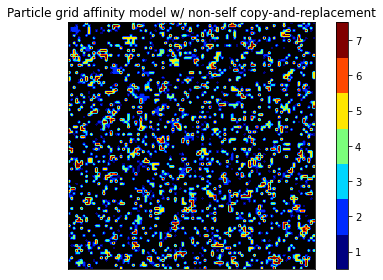

In [139]:
#run the simulation from scratch
#if it is a new simulation we generate random rules and particle starting positions
params = {"steps":2,
          "history":[],
          "length":100,
          "num_types":7,
          "density":0.25,
          "radius":2,
          "pos":[0,0],
          "best_idx":[0,0]}

#we continue to fill out the params dictionary by reference the parameters already in the dictionary
#i wanted to have type of None for empty cells, but matplotlib plotting doesn't handle heatmaps of int and None well
#therefore type 0 represents a blank cell, which is not really a particle 
#some of idx or range() references below reflect this programming design decision
def dict_creator(params):
    params["type_grid"]=[[np.random.choice(a=[np.random.choice([i for i in range(params['num_types']+1) if i != 0]), 0], p=[params['density'], 1-params['density']]) for _ in range(params['length'])] for _ in range(params['length'])]
    params["copy_type"]=[np.random.choice([i for i in range(params['num_types']+1) if i!=type_idx and i!=0]) for type_idx in range(params['num_types']+1)] #can't copy self so remove i
    params["replace_type"]=[np.random.choice([i for i in range(1, params['num_types']+1) if i!=type_idx and i!=params["copy_type"][type_idx]]) for type_idx in range(params['num_types']+1)] #can't replace self too? 
    if np.random.choice([0,1])==0:
        #make particles automatically attracted to their own type and randomly attracted to other types
        params["affinity"]=[[np.random.choice(a=[0,1]) if i!=j else 1 for i in range(params["num_types"]+1)] for j in range(params["num_types"]+1)]
    else:
        #make partilces randomly attracted to all types inluding their own type
        params["affinity"]=np.random.choice(a=[0,1], size=(params["num_types"]+1, params["num_types"]+1)) #particles don't need to be attracted to themselves
    return params

#create complete params dictionary
params_dict = dict_creator(params)

#create a class object and then run the run method
particle_sim = ParticleGrid(params_dict)
particle_sim.run()

Particles of type 0 are actually blank cells.
Therefore index 0 can be ignored in the affinity, copy, and replace lists.

Particle affinity w/ respect to other particles:
[[1 0 1 0 1 1 1 1]
 [1 0 1 0 0 0 0 1]
 [1 1 1 0 1 1 1 1]
 [0 1 0 0 0 1 1 1]
 [0 1 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 1]
 [1 1 1 0 0 0 0 1]
 [0 1 1 1 0 0 0 1]]

copy particle of this type: [2, 3, 6, 2, 7, 4, 4, 2]
replace particle this type: [3, 4, 3, 1, 6, 6, 1, 4]

The first few steps, along with every tenth step, will print out particle distribution information and save a snapshot.

step 0 of 2
length of history: 2
10000 particles. Distribution: [7550, 316, 399, 349, 311, 364, 340, 371]

step 1 of 2
length of history: 3
10000 particles. Distribution: [7550, 313, 405, 349, 308, 364, 336, 375]


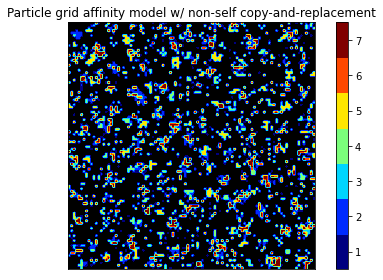

In [140]:
#if you stop the simulation early, you can restart it where it left off with this code
params_dict = {"steps": particle_sim.steps,
               "history":particle_sim.history,
               "length":particle_sim.length,
               "num_types":particle_sim.num_types,
               "density":particle_sim.density,
               "radius":particle_sim.radius,
               "pos":particle_sim.pos,
               "best_idx":particle_sim.best_idx,
               "type_grid":particle_sim.type_grid,
               "affinity":particle_sim.affinity,
               "copy_type":particle_sim.copy_type,
               "replace_type":particle_sim.replace_type} 

particle_sim = ParticleGrid(params_dict)
particle_sim.run()

In [141]:
#or you can save the simulation history and parameters to a json file to continue the run later with this code
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyArrayEncoder, self).default(obj)

params_dict = {"steps":particle_sim.steps,
               "history":particle_sim.history,
               "length":particle_sim.length,
               "num_types":particle_sim.num_types,
               "density":particle_sim.density,
               "radius":particle_sim.radius,
               "pos":particle_sim.pos,
               "best_idx":particle_sim.best_idx,
               "type_grid":particle_sim.type_grid,
               "affinity":particle_sim.affinity,
               "copy_type":particle_sim.copy_type,
               "replace_type":particle_sim.replace_type}

with open('params_and_history.json', 'w') as fp: #"fp" is file pointer
    json.dump(params_dict, fp, cls=NumpyArrayEncoder)

Particles of type 0 are actually blank cells.
Therefore index 0 can be ignored in the affinity, copy, and replace lists.

Particle affinity w/ respect to other particles:
[[1, 0, 1, 0, 1, 1, 1, 1], [1, 0, 1, 0, 0, 0, 0, 1], [1, 1, 1, 0, 1, 1, 1, 1], [0, 1, 0, 0, 0, 1, 1, 1], [0, 1, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 1], [1, 1, 1, 0, 0, 0, 0, 1], [0, 1, 1, 1, 0, 0, 0, 1]]

copy particle of this type: [2, 3, 6, 2, 7, 4, 4, 2]
replace particle this type: [3, 4, 3, 1, 6, 6, 1, 4]

The first few steps, along with every tenth step, will print out particle distribution information and save a snapshot.

step 0 of 2
length of history: 4
10000 particles. Distribution: [7550, 311, 407, 349, 308, 364, 333, 378]

step 1 of 2
length of history: 5
10000 particles. Distribution: [7550, 308, 410, 348, 308, 364, 329, 383]


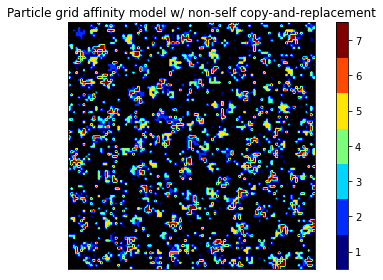

In [142]:
#you can load the simulation history and params saved in the json and continue running the simulation where you left off
with open('params_and_history.json') as json_file:
    params_dict = json.load(json_file)

particle_sim = ParticleGrid(params_dict)
particle_sim.run()

In [137]:
#or you can also make a gif of the simulation after you stop the code
particle_sim.get_gif()